# IPM-407 Proyecto 2
## Métodos basados en transformadas de Fourier

Sea la siguiente ecuación de Poisson

$$\frac{\partial^2 \phi}{\partial x^2}+\frac{\partial^2 \phi}{\partial y^2}=\frac{1}{\pi^2}\left[ 30\left(\left(\frac{x}{\pi}\right)^2-\frac{x}{\pi}\right)+30\left(\left(\frac{y}{\pi}\right)^2-\frac{y}{\pi}\right)-4\pi^2\left(\frac{x}{\pi}-1\right)\sin(2y)\right]$$


en el cuadrado $0\leq x\leq \pi$ y $0\leq y \leq \pi$ con condiciones de contorno $\phi(0,y) = \phi(\pi,y)=\phi(x,0) =\phi(x,\pi)=0$. 

El objetivo de este proyecto es resolver esta ecuación de Poisson con dichas condiciones usando:

1. Método espectral
2. Diferencias finitas aceleradas con FFT en 2D
3. Diferencias finitas aceleradas con FFT en 1D

Para hacer la comparación se utilizaran mallas de $N=16,$ $32,$ $64,$ $128$ nodos para la dirección $x$ e $y$\\

Ademas se sabe que la solución analitica para esta ecuación es:

$$\phi(x,y)=15\left(\left(\frac{x}{\pi}  \right)^2-\frac{x}{\pi}\right)\left(\left(\frac{y}{\pi}  \right)^2-\frac{y}{\pi}\right)-\sin(2y)\frac{\sinh(2\pi(\frac{x}{\pi}-1))}{\sinh(2\pi)}+\left(\frac{x}{\pi}-1 \right)\sin(2y) $$


## Preambulo

En un primer momento se importan las librerias que seran necesarias para los calculos a realizar.


In [1]:
#se importan las librerias necesarias
import numpy
import math
from numpy import pi, sin, cos, exp, real, imag, sinh, empty, zeros
from time import time

from numpy.fft import rfft,irfft

from matplotlib import pyplot, cm
from matplotlib import rcParams
from numba import jit
from scipy import sparse
from scipy.sparse.linalg import spsolve
%matplotlib inline

rcParams['font.family'] = 'serif'
rcParams['font.size'] = 8

Se llamara $f$ la función que se observa en el miembro derecgo de la ecuación de poisson, es decir_

$$f(x,y)=\frac{1}{\pi^2}\left[ 30\left(\left(\frac{x}{\pi}\right)^2-\frac{x}{\pi}\right)+30\left(\left(\frac{y}{\pi}\right)^2-\frac{y}{\pi}\right)-4\pi^2\left(\frac{x}{\pi}-1\right)\sin(2y)\right]$$

A continuación se estableceran las rutinas que permita calcular cada uno de los valores de $f$ dentro de la malla y el valor teorico de la función $\phi$

In [2]:
# @jit
def function_f(h,N):
    f = empty([N,N], dtype=float)
    for j in range(N):
        for i in range(N):
            f[j,i] = (1/pi**2)*(30.*(((i*h/pi)**2)-i*h/pi)+30.*(((j*h/pi)**2)-j*h/pi)
                               -4.*(pi**2)*((i*h/pi)-1)*sin(2*j*h))
    return f


def phi_teorico(h,N):
    phi = empty([N,N], dtype=float)
    for j in range(N):
        for i in range(N):
            phi[j,i] = (15.*(((i*h/pi)**2)-(i*h/pi))*(((j*h/pi)**2)-(j*h/pi))
                        -sin(2.*j*h)*(sinh(2.*pi*((i*h/pi)-1))/sinh(2.*pi))
                        + ((i*h/pi)-1)*sin(2.*j*h))
    return phi


# Con la siguiente función se pretende ordenar vectores en forma de matriz para asi poder determinar maximos
# en caso de ser necesario.
@jit
def matrix_to_vector(matrix,N):
    NN = (N-2)*(N-2)
    vector = numpy.empty([NN])
    j = 1
    k = 1
    for i in range(NN):
        vector[i] = matrix[j,k]
        k = k+1
        if k == (N):
            j = j+1
            k = 1
       
    return vector

# Recive un vector y devuelve la norma infinita y la norma eclideana del vector.
def norma(vector,H):
    norm = numpy.zeros(2)
    norm[0] = max(abs(vector))
    norm[1] = H*(sum(vector**2)**(0.5))
    return norm

## Transformada discreta del Seno



In [3]:
######################################################################
# 1D DST Type-I

def dst(y):
    N = len(y)
    y2 = empty(2*N,float)
    y2[0] = y2[N] = 0.0
    y2[1:N] = y[1:]
    y2[:N:-1] = -y[1:]
    a = -imag(rfft(y2))[:N]
    a[0] = 0.0

    return a


######################################################################
# 1D inverse DST Type-I

def idst(a):
    N = len(a)
    c = empty(N+1,complex)
    c[0] = c[N] = 0.0
    c[1:N] = -1j*a[1:]
    y = irfft(c)[:N]
    y[0] = 0.0

    return y


######################################################################
# 2D DST

def dst2(y):
    M = y.shape[0]
    N = y.shape[1]
    a = empty([M,N],float)
    b = empty([M,N],float)

    for i in range(M):
        a[i,:] = dst(y[i,:])
    for j in range(N):
        b[:,j] = dst(a[:,j])

    return b


######################################################################
# 2D inverse DST

def idst2(b):
    M = b.shape[0]
    N = b.shape[1]
    a = empty([M,N],float)
    y = empty([M,N],float)

    for i in range(M):
        a[i,:] = idst(b[i,:])
    for j in range(N):
        y[:,j] = idst(a[:,j])

    return y

In [61]:
def thomassolve(a,b,c,d):
    '''
    b: diagonal principal
    a y c: diagonales secundarias
    d: vector del sistema Ax = d
    x: solcion del sistema
    '''
    
    n = len(b)
    
    cth = numpy.empty([n-1], dtype=float)
    dth = numpy.empty([n], dtype=float)
    xth = numpy.empty([n], dtype=float)
    
    cth[0] = c[0]/b[0]
    dth[0] = d[0]/b[0]
    
    for i in range(1,n-1):
        cth[i] = c[i]/(b[i]-cth[i-1]*a[i-1])
    for i in range(1,n):
        dth[i] = (d[i]-dth[i-1]*a[i-1])/(b[i]-cth[i-1]*a[i-1])
    
    xth[n-1] = dth[n-1]
    
    for i in range(n-2,-1,-1):
        xth[i] = dth[i]-cth[i]*xth[i+1]
    
    return xth

In [50]:
def TDMASolve(a, b, c, d):
    nmax = len(d)#n in the numbers is rows

    # Modify the first-row coefficients
    c[0] /= b[0] #Division by zero risk.
    d[0] /= b[0]

    for i in xrange(1, nmax):
        ptemp = b[i] - (a[i] * c[i-1])
        c[i] /= ptemp
        d[i] = (d[i] - a[i] * d[i-1])/ptemp

    #Back Substitution
    x = [0 for i in xrange(nmax)]
    x[-1] = d[-1]
    for i in range(-2,-nmax-1,-1):
        x[i] = d[i] - c[i] * x[i+1]
 	return x

## Solvers

In [63]:
#@jit
def solve_espectral(h,N):
    f = function_f(h,N)
    ff = dst2(f)
    pphi = zeros([N,N])
    for l in range(1,N-1):
        for k in range(1,N-1):
            pphi[l,k] = -ff[l,k]/((l**2)+(k**2))
    phi = idst2(pphi)
    
    return phi

#@jit
def solve_DF_2D(h,N):
    f = function_f(h,N)
    ff = dst2(f)
    pphi = zeros([N,N])
    for l in range(1,N-1):
        for k in range(1,N-1):
            pphi[l,k] = ff[l,k]*(h**2)/(2*(cos(k*h)+cos(l*h))-4)
    phi = idst2(pphi)
    
    return phi

#@jit
def solve_DF_1D(h,N):
    f = function_f(h,N)
    ff = zeros((N, N))
    for j in range(N):
        ff[:, j] = dst(f[:, j])
    pphi = numpy.zeros((N, N))
    c = empty([N-1], dtype=float)
    c[:] = -1.
    for k in range(N):
        a = empty(N, dtype=float)
        a[:] = 4. - 2.*cos(k*h)
        b = zeros(N)
        for j in range(N):
            b[j] = -h**2 * ff[k, j]
        pphi[k, :] = thomassolve(c, a, c, b)
    phi = zeros((N, N))
    for j in range(N):
        phi[:, j] = idst(pphi[:, j])        
    return phi 
                

In [64]:
N_in=16
Num_mallas = 4
N = empty(Num_mallas, dtype=int)

for i in range(len(N)):
    N[i]=N_in*2**i
    #N[i]=((N_in)*2**i)+1

L = pi

error_inf = empty([3,len(N)], dtype=float)
error_eu = empty([3,len(N)], dtype=float)
tiempo = empty([3,len(N)],dtype=float)


for i in range(len(N)):
    h = L/(N[i]-1)
    X = numpy.linspace(0.0,L, N[i]) # Posicion de los nodos en x
    Y = numpy.linspace(0.0,L, N[i]) # Posicion de los nodos en y
    phi_teo_aux = phi_teorico(h,N[i])

    t1 = time()
    phi_espectral_aux = solve_espectral(h,N[i])
    t2 = time()
    tiempo[0,i] = t2-t1
    error_espectral_M = phi_teo_aux-phi_espectral_aux
    error_espectral_V = matrix_to_vector(error_espectral_M,N[i])
    error_espectral = norma(error_espectral_V,h)
    error_inf[0,i] = error_espectral[0]
    error_eu[0,i] = error_espectral[1]

    t1 = time()
    phi_DF_2D_aux = solve_DF_2D(h,N[i])
    t2 = time()
    tiempo[1,i] = t2-t1
    error_DF_2D_M = phi_teo_aux-phi_DF_2D_aux
    error_DF_2D_V = matrix_to_vector(error_DF_2D_M,N[i])
    error_DF_2D = norma(error_DF_2D_V,h)
    error_inf[1,i] = error_DF_2D[0]
    error_eu[1,i] = error_DF_2D[1]

    t1 = time()
    phi_DF_1D_aux = solve_DF_1D(h,N[i])
    t2 = time()
    tiempo[2,i] = t2-t1
    error_DF_1D_M = phi_teo_aux-phi_DF_1D_aux
    error_DF_1D_V = matrix_to_vector(error_DF_1D_M,N[i])
    error_DF_1D = norma(error_DF_1D_V,h)
    error_inf[2,i] = error_DF_1D[0]
    error_eu[2,i] = error_DF_1D[1]
    
    print 'Metodos:    Espectral        | DF 2D             | DF 1D'
    print 'cantidad de nodos:', N[i],'x',N[i]
    print 'error inf: ',error_inf[0,i],'| ',error_inf[1,i],'| ',error_inf[2,i]
    print 'error eu:  ',error_eu[0,i],' | ',error_eu[1,i],' | ',error_eu[2,i]
    print 'tiempo:    ',tiempo[0,i],'   | ',tiempo[1,i],'   | ',tiempo[2,i]
    print
    
print 'fin'


Metodos:    Espectral        | DF 2D             | DF 1D
cantidad de nodos: 16 x 16
error inf:  0.223718847477 |  0.225606613031 |  0.362772584994
error eu:   0.225334477868  |  0.229612891057  |  0.454444426312
tiempo:     0.00405597686768    |  0.00446605682373    |  0.00324702262878

Metodos:    Espectral        | DF 2D             | DF 1D
cantidad de nodos: 32 x 32
error inf:  0.137165243836 |  0.138121186243 |  0.215350793588
error eu:   0.139064547955  |  0.140410869643  |  0.254580852963
tiempo:     0.00853395462036    |  0.0115761756897    |  0.0090868473053

Metodos:    Espectral        | DF 2D             | DF 1D
cantidad de nodos: 64 x 64
error inf:  0.086833567908 |  0.0870217916489 |  0.117741493807
error eu:   0.0786376886213  |  0.0789921730973  |  0.134520202876
tiempo:     0.0217928886414    |  0.0343799591064    |  0.0262579917908

Metodos:    Espectral        | DF 2D             | DF 1D
cantidad de nodos: 128 x 128
error inf:  0.0483810281909 |  0.048422569319 |  0.0

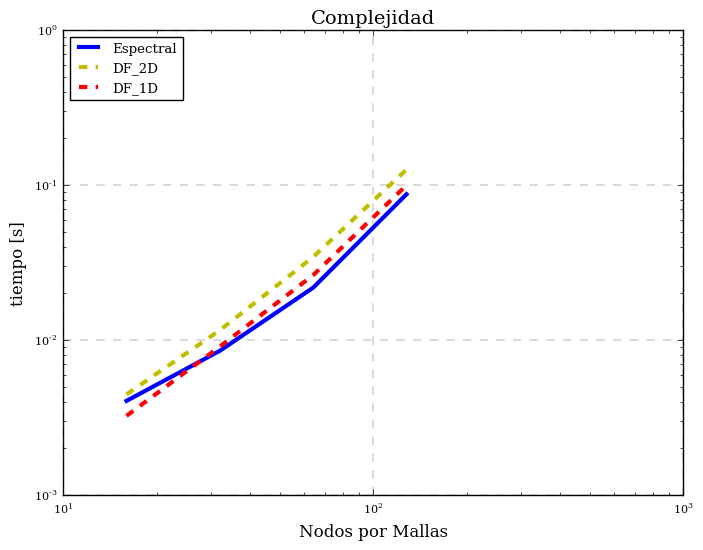

In [65]:
fig = pyplot.figure(num = None, figsize = (8, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
NvstEespectral = pyplot.plot(N, tiempo[0,:], 'b-',linewidth = 3, label = 'Espectral')
NvstEDF2D = pyplot.plot(N, tiempo[1,:], 'y--', linewidth = 3,label = 'DF_2D')
NvstEDF1D = pyplot.plot(N, tiempo[2,:], 'r--', linewidth = 3, label = 'DF_1D')

pyplot.legend(loc = 2)
pyplot.xscale("log")
pyplot.yscale("log")
pyplot.title("Complejidad", fontsize = 14)
pyplot.xlabel("Nodos por Mallas", fontsize = 12)
pyplot.ylabel("tiempo [s]", fontsize = 12)
#pyplot.axis([10**(1.5),10**5,10**(-2),10**3.8])
pyplot.grid(True)
pyplot.grid(color = '0.3', linestyle = '--', linewidth = 0.3)
pyplot.show()



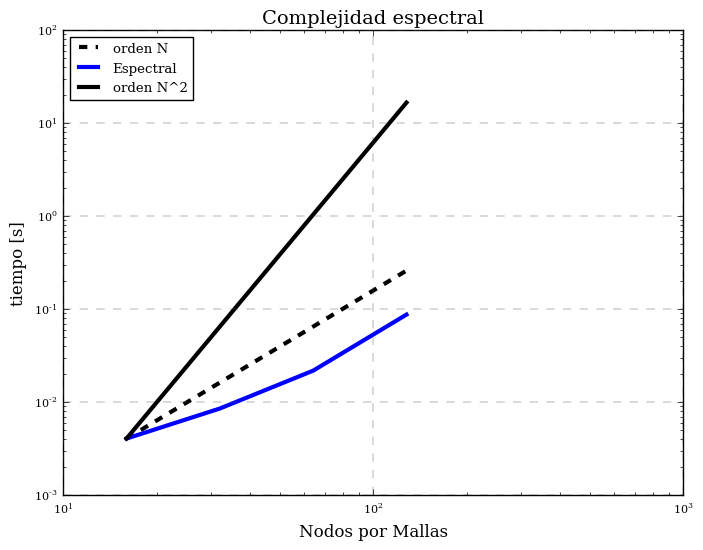

In [66]:
#Complegidad espectral

tiempo_o_espectral = empty([2,len(N)], dtype=float)
#print tiempo[0]
#print tiempo[0,1]

for i in range(len(N)):
    tiempo_o_espectral[0,i] = tiempo[0,0]*4**i
    tiempo_o_espectral[1,i] = tiempo[0,0]*4**(2*i)

fig = pyplot.figure(num = None, figsize = (8, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
NvstEespectraloN = pyplot.plot(N[:], tiempo_o_espectral[0,:], 'k--',linewidth = 3, label = 'orden N')
NvstEespectral = pyplot.plot(N[:], tiempo[0,:], 'b-',linewidth = 3, label = 'Espectral')
NvstEespectraloN2 = pyplot.plot(N[:], tiempo_o_espectral[1,:], 'k-',linewidth = 3, label = 'orden N^2')


pyplot.legend(loc = 2)
pyplot.xscale("log")
pyplot.yscale("log")
pyplot.title("Complejidad espectral", fontsize = 14)
pyplot.xlabel("Nodos por Mallas", fontsize = 12)
pyplot.ylabel("tiempo [s]", fontsize = 12)
#pyplot.axis([10**(1.5),10**5,10**(-2),10**3.8])
pyplot.grid(True)
pyplot.grid(color = '0.3', linestyle = '--', linewidth = 0.3)
pyplot.show()

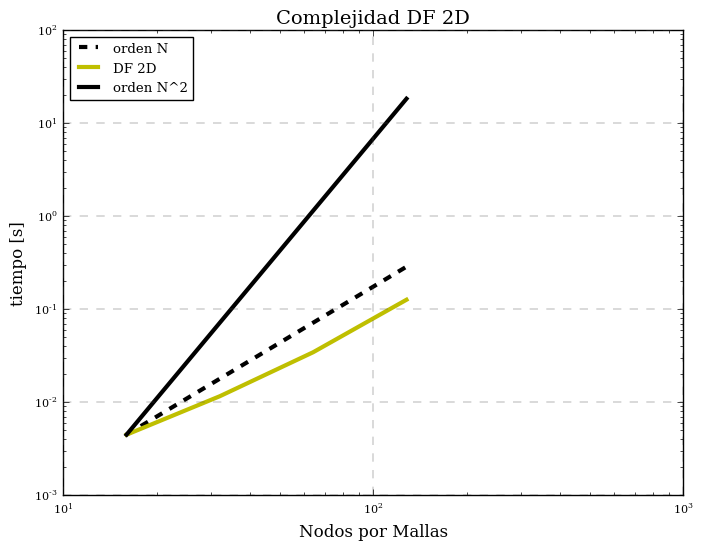

In [67]:
#Complegidad diferencias finitas 2D

tiempo_o_DF2D = empty([2,len(N)], dtype=float)
#print tiempo[0]
#print tiempo[0,1]

for i in range(len(N)):
    tiempo_o_DF2D[0,i] = tiempo[1,0]*4**i
    tiempo_o_DF2D[1,i] = tiempo[1,0]*4**(2*i)

fig = pyplot.figure(num = None, figsize = (8, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
Nvst2DoN = pyplot.plot(N[:], tiempo_o_DF2D[0,:], 'k--',linewidth = 3, label = 'orden N')
Nvst2D = pyplot.plot(N[:], tiempo[1,:], 'y-',linewidth = 3, label = 'DF 2D')
Nvst2DoN2 = pyplot.plot(N[:], tiempo_o_DF2D[1,:], 'k-',linewidth = 3, label = 'orden N^2')


pyplot.legend(loc = 2)
pyplot.xscale("log")
pyplot.yscale("log")
pyplot.title("Complejidad DF 2D", fontsize = 14)
pyplot.xlabel("Nodos por Mallas", fontsize = 12)
pyplot.ylabel("tiempo [s]", fontsize = 12)
#pyplot.axis([10**(1.5),10**5,10**(-2),10**3.8])
pyplot.grid(True)
pyplot.grid(color = '0.3', linestyle = '--', linewidth = 0.3)
pyplot.show()

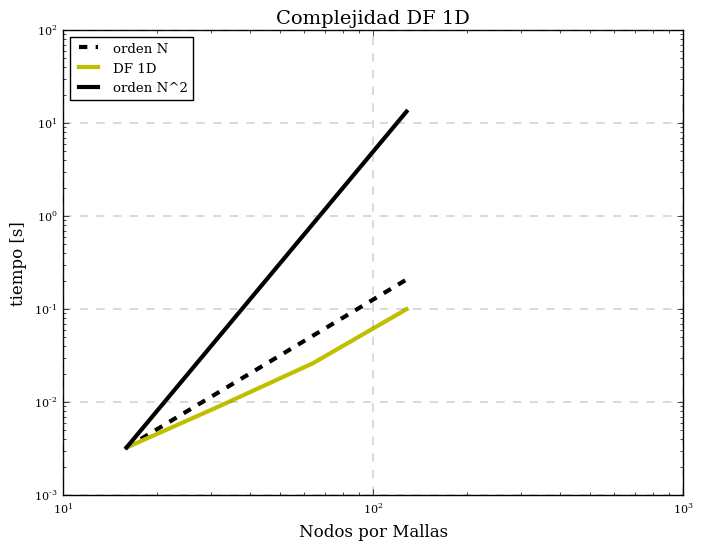

In [68]:
#Complegidad diferencias finitas 1D

tiempo_o_DF1D = empty([2,len(N)], dtype=float)
#print tiempo[0]
#print tiempo[0,1]

for i in range(len(N)):
    tiempo_o_DF1D[0,i] = tiempo[2,0]*4**i
    tiempo_o_DF1D[1,i] = tiempo[2,0]*4**(2*i)

fig = pyplot.figure(num = None, figsize = (8, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
Nvst1DoN = pyplot.plot(N[:], tiempo_o_DF1D[0,:], 'k--',linewidth = 3, label = 'orden N')
Nvst1D = pyplot.plot(N[:], tiempo[2,:], 'y-',linewidth = 3, label = 'DF 1D')
Nvst1DoN2 = pyplot.plot(N[:], tiempo_o_DF1D[1,:], 'k-',linewidth = 3, label = 'orden N^2')


pyplot.legend(loc = 2)
pyplot.xscale("log")
pyplot.yscale("log")
pyplot.title("Complejidad DF 1D", fontsize = 14)
pyplot.xlabel("Nodos por Mallas", fontsize = 12)
pyplot.ylabel("tiempo [s]", fontsize = 12)
#pyplot.axis([10**(1.5),10**5,10**(-2),10**3.8])
pyplot.grid(True)
pyplot.grid(color = '0.3', linestyle = '--', linewidth = 0.3)
pyplot.show()

[ 16  32  64 128]


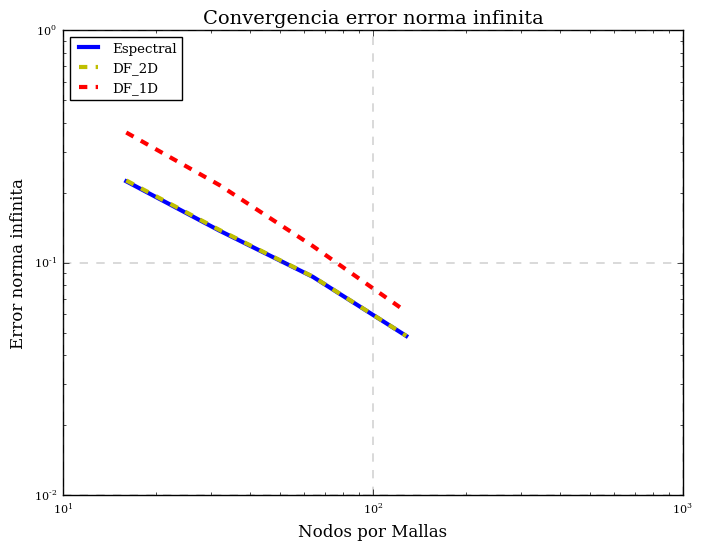

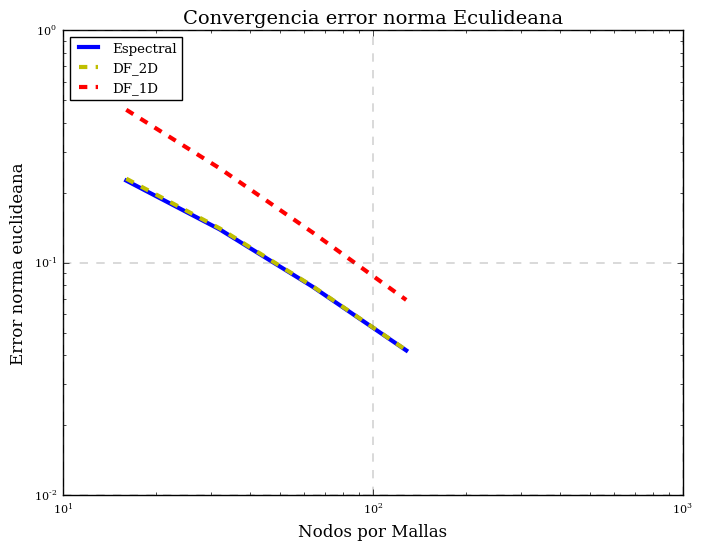

In [69]:
print N    
    
fig = pyplot.figure(num = None, figsize = (8, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
NvsEespectral = pyplot.plot(N, error_inf[0,:], 'b-',linewidth = 3, label = 'Espectral')
NvsEDF2D = pyplot.plot(N, error_inf[1,:], 'y--', linewidth = 3,label = 'DF_2D')
NvsEDF1D = pyplot.plot(N, error_inf[2,:], 'r--', linewidth = 3, label = 'DF_1D')

pyplot.legend(loc = 2)
pyplot.xscale("log")
pyplot.yscale("log")
pyplot.title("Convergencia error norma infinita", fontsize = 14)
pyplot.xlabel("Nodos por Mallas", fontsize = 12)
pyplot.ylabel("Error norma infinita", fontsize = 12)
#pyplot.axis([10**(1.5),10**5,10**(-2),10**3.8])
pyplot.grid(True)
pyplot.grid(color = '0.3', linestyle = '--', linewidth = 0.3)
pyplot.show()

fig = pyplot.figure(num = None, figsize = (8, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
NvsEespectral = pyplot.plot(N, error_eu[0,:], 'b-',linewidth = 3, label = 'Espectral')
NvsEDF2D = pyplot.plot(N, error_eu[1,:], 'y--', linewidth = 3,label = 'DF_2D')
NvsEDF1D = pyplot.plot(N, error_eu[2,:], 'r--', linewidth = 3, label = 'DF_1D')

pyplot.legend(loc = 2)
pyplot.xscale("log")
pyplot.yscale("log")
pyplot.title("Convergencia error norma Eculideana", fontsize = 14)
pyplot.xlabel("Nodos por Mallas", fontsize = 12)
pyplot.ylabel("Error norma euclideana", fontsize = 12)
#pyplot.axis([10**(1.5),10**5,10**(-2),10**3.8])
pyplot.grid(True)
pyplot.grid(color = '0.3', linestyle = '--', linewidth = 0.3)
pyplot.show()

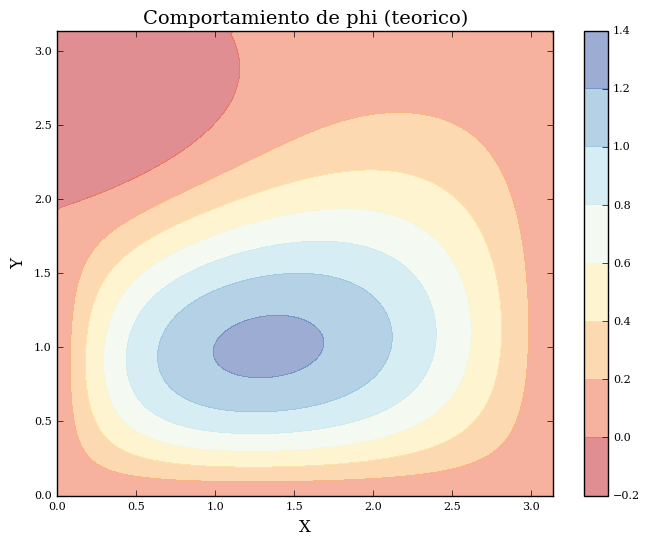

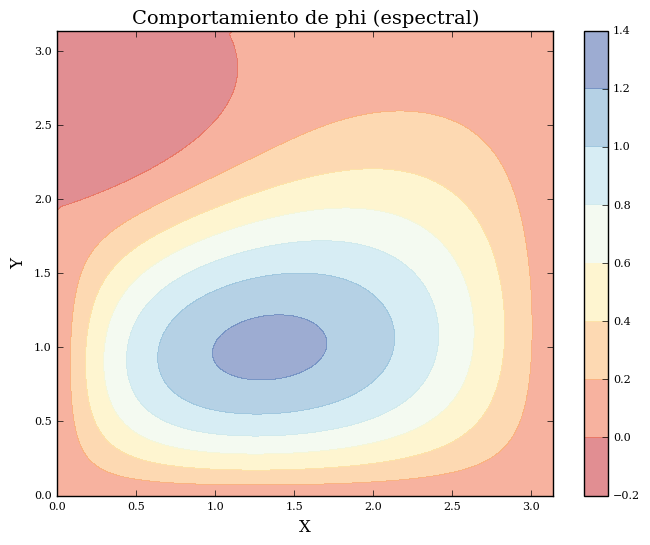

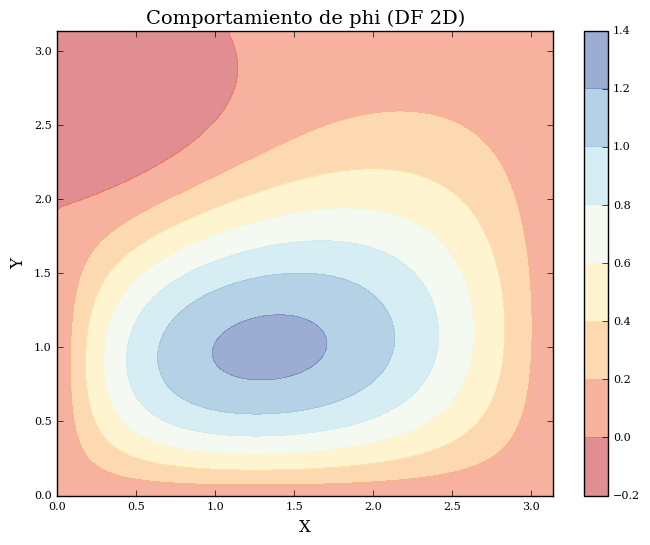

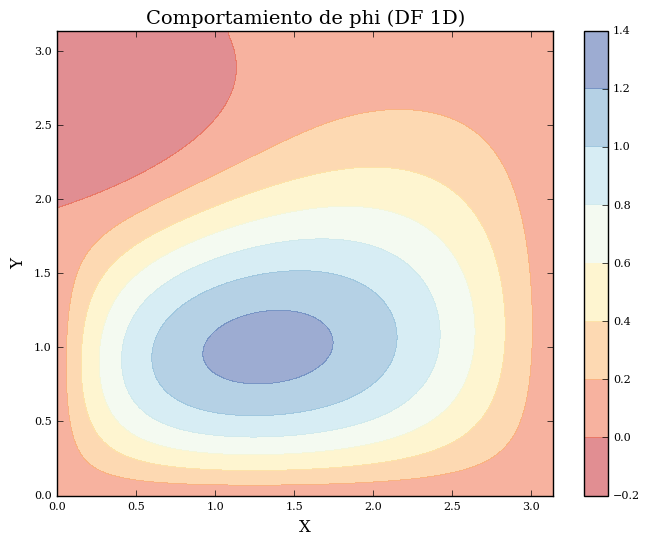

In [70]:
N_finito = N[len(N)-1]

phi_teo = numpy.empty([N_finito,N_finito], dtype=float)
phi_espectral = numpy.empty([N_finito,N_finito], dtype=float)
phi_DF_2D = numpy.empty([N_finito,N_finito], dtype=float)
phi_DF_1D = numpy.empty([N_finito,N_finito], dtype=float)


for i in range(N_finito):
    phi_teo[(N_finito-1)-i,:]=phi_teo_aux[i,:]
    phi_espectral[(N_finito-1)-i,:]=phi_espectral_aux[i,:]
    phi_DF_2D[(N_finito-1)-i,:]=phi_DF_2D_aux[i,:]
    phi_DF_1D[(N_finito-1)-i,:]=phi_DF_1D_aux[i,:]
    

fig = pyplot.figure(figsize=(8,6), dpi=50)
pyplot.contourf(X, Y, phi_teo, alpha=0.5,facecolor = 'w', cmap=cm.RdYlBu)
pyplot.colorbar()
pyplot.title('Comportamiento de phi (teorico)', fontsize = 14)
pyplot.xlabel('X', fontsize = 12)
pyplot.ylabel('Y', fontsize = 12)

fig = pyplot.figure(figsize=(8,6), dpi=50)
pyplot.contourf(X, Y, phi_espectral, alpha=0.5,facecolor = 'w', cmap=cm.RdYlBu)
pyplot.colorbar()
pyplot.title('Comportamiento de phi (espectral)', fontsize = 14)
pyplot.xlabel('X', fontsize = 12)
pyplot.ylabel('Y', fontsize = 12)

fig = pyplot.figure(figsize=(8,6), dpi=50)
pyplot.contourf(X, Y, phi_DF_2D, alpha=0.5,facecolor = 'w', cmap=cm.RdYlBu)
pyplot.colorbar()
pyplot.title('Comportamiento de phi (DF 2D)', fontsize = 14)
pyplot.xlabel('X', fontsize = 12)
pyplot.ylabel('Y', fontsize = 12)

fig = pyplot.figure(figsize=(8,6), dpi=50)
pyplot.contourf(X, Y, phi_DF_1D, alpha=0.5,facecolor = 'w', cmap=cm.RdYlBu)
pyplot.colorbar()
pyplot.title('Comportamiento de phi (DF 1D)', fontsize = 14)
pyplot.xlabel('X', fontsize = 12)
pyplot.ylabel('Y', fontsize = 12)

In [51]:
c = empty(3)
c[:] = 1

print c

[ 1.  1.  1.]
